## Chapter 12: Introduction to nonlinear learning

# 12.2  Features, functions, and nonlinear classification

In this Section we introduce the general framework of nonlinear classification, along with many examples.  These examples are all low dimensional, allowing us to visually examine patterns in the data and propose appropriate nonlinearities, which we can (as we will see) very quickly inject into our linear supervised paradigm to produce nonlinear classifications.  Just as with the previous Section by walking through these examples we flush out a number important concepts in concrete terms, coding principles, and jargon-terms in a relatively simple environment that will be omnipresent in our discussion of nonlinear learning going forward.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib

# demos for this notebook
classif_plotter = nonlib.nonlinear_classification_demos
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
sup_datapath = '../../mlrefined_datasets/superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 12.2.1  Modeling principles linear and nonlinear two class classification

In Chapters 9 and 10 we detailed the principles and practices linear classification learning.  In the case of two class linear classification - where our labels take on assumed values of $-1$ and $+1$ - we aim at determinig the proper parameters $\mathbf{w}$ of a linear `model`

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right)  = \mathbf{x}^T \mathbf{w}
\end{equation}

that the corresponding linear decision boundary

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathbf{x}^T \mathbf{w} = 0
\end{equation}

separates the two classes as well as is possible using a linear model (here we will use the same compact notation used in the previous Section).  We then saw in Chapter 9 that a number of cost functions of our `model` can be used to determine these ideal parameters e.g., the softmax cost function

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\text{log}\left(1 + e^{-y_p\text{model}\left(\mathbf{x}_p,\mathbf{w}\right)}\right)
\end{equation}

whose minimum provides us with the weights that service our ideal as best as possible.

#### <span style="color:#a50e3e;">Example 1. </span>  The perfect dataset for linear two class classification

Examining our setup, here for linear two-classification our perfect dataset would consist of points where $\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) = y_p$, i.e., points lying perfectly on the step function with linear boundary given by $\text{model}\left(\mathbf{x},\mathbf{w}\right) = 0$.  The most perfect dataset we could possibly have for linear classification is then - ignoring computation - a perfect step function (with linear boundary) itself.  This is illustrated below in the animated gif.

<figure>
<p>
<img src= '../../mlrefined_images/nonlinear_superlearn_images/linear_classification_to_funcapprox.gif' width="80%" height="80%" alt=""/>
</p>
<figcaption> <strong>Figure 1:</strong> <em> 
In this gif we start off by showing a realistic linear classification dataset (a small noisy set of points that can be roughly modeled by a step function).  We then progress to remove all noise from those points (i.e., returning the true label values to our 'noisy' points), and finally show the perfect linear classification scenario where we have infinitely many points lying perfectly on a step function with linear boundary. 
</em>
</figcaption>
</figure>

If we go back and examine any of the arguments in Chaper 9 used to derive logistic regression, the perceptron, or support vector machines nothing in any of these arguments relied on our use of a *linear* model: a nonlinear assumption about how the classes of a dataset are distributed would lead to the same formulae  and cost functions (employing our `model` notation).  In other words we could have just as well started with (instead of equation (1)) with the supposition of a nonlinear model

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right)  = 
w_0^{\,} + {w}_{1}^{\,}\,f\left(\mathbf{x}_p\right)
\end{equation}

where here $f$ is some nonlinear function or *feature transformation*.  To determine ideal weights we would follow the same logic as when our `model` was a linear one, and minimize an appropriate cost function of this nonlinear `model` to determine the appropriate *nonlinear decision boundary* $\text{model}\left(\mathbf{x},\mathbf{w}\right)  = 0$.  

<figure>
<p>
<img src= '../../mlrefined_images/nonlinear_superlearn_images/nonlinear_classification.png' width="80%" height="80%" alt=""/>
</p>
<figcaption> <strong>Figure 2:</strong> <em> 
A figurative drawing of the nonlinear two-class classification scenario, which we can achieve by injecting nonlinear feature transformations into our `model` in precisely the same way we did in the previous Section with nonlinear regression.  In the top panel we show the 'regression' perspective on two-class classification, where in the nonlinear context we aim to learn a step function with *nonlinear* boundary that separates the two classes of our data as best as possible.  From the 'separator' point of view we aim to simultaneously learn a proper nonlinear boundary that separates the two classes. 
</em>
</figcaption>
</figure>


This was precisely the same scenario we found with nonlinear regression in the prior Section as well, and just as with nonlinear regression we could in general just as well use a weighted sum of $B$ nonlinear functions of our input as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + {w}_{1}\,f_1\left(\mathbf{x}_p\right) +  {w}_{2}\,f_2\left(\mathbf{x}_p\right) + \cdots + w_B\,f_B\left(\mathbf{x}_p\right)  
\end{equation}

where $f_1,\,f_2,\,...\,f_B$ are nonlinear feature transformations and $w_0$ through $w_B$ - as well as any weights internal to the nonlinear functions - are represented in the weight set $\mathbf{w}$ and must be tuned properly to determine a proper *nonlinear decision boundary*.

#### <span style="color:#a50e3e;">Example 2. </span>  The perfect dataset for two class nonlinear classification

Examining our setup, here for nonlinear two-classification our perfect dataset would consist of points where the nonlinear decision boundary given by $\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) = 0$ perfectly separates the data.  In other words, that our points lie perfectly on the step function with this nonlinear boundary.  The most perfect dataset we could possibly have for nonlinear classification is then - ignoring computation - a perfect step function (with nonlinear boundary) itself.  This is illustrated below in the animated gif.

<figure>
<p>
<img src= '../../mlrefined_images/nonlinear_superlearn_images/nonlinear_classification_to_funcapprox.gif' width="80%" height="80%" alt=""/>
</p>
<figcaption> <strong>Figure 3:</strong> <em> 
In this gif we start off by showing a realistic nonlinear classification dataset (a small noisy set of points that can be roughly modeled by a step function with nonlinear boundary).  We then progress to remove all noise from those points (i.e., returning the true label values to our 'noisy' points), and finally show the perfect nonlinear classification scenario where we have infinitely many points lying perfectly on a step function with nonlinear boundary. 
</em>
</figcaption>
</figure>

## 12.2.2.  Simple examples of nonlinear two class classification

For some low-dimensional problems we can determine a proper nonlinearity for regression or classification 'by eye', that is by examining a dataset visually.  For other more classic low-dimensional problems - particularly with nonlinear regression - one can additionally reason out an appropriate nonlinearity using domain knowledge from physics and economics via so-called *differential equations*.

In this section we explore several examples in the former category - datasets that we can visualize and whose nonlinear patterns are simple enough for us to be able to identify by eye.  These examples will allow us to introduce a number of important principles, formulations, and jargon-terms - that we will see considerably more of when discussing neural networks, tree-based learners, and kernels - in a comparatively simple context.

Mirroring Section 12.1.2 the examples here differ largely only in how their respective feature transformations are implemented.  For example, for the examples here we will employ the simple and efficient implementation of the softmax cost function first described in Section 8.1 in the context of two class logistic regression.

In [2]:
def softmax(w):
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w))))
    return cost/float(len(y))

The `model` functionality for these examples looks precisely as it did in Section 12.1.2, given below for the general case where our feature transformations `feature_transforms` consists of functions having internal parameters.  The same comments made previously about the slight variations in this model - depending on whether or not `feature_transforms` takes in internal parameters - applies here as well.  In other words, our focus with these simple examples here - as well as the more complex ones in the following Sections and Chapters - will be solely in how to design and implement feature transformations in the module `feature_transforms`.  All of the other required functionality e.g., cost functions, `model` function, normalization schemes, and gradient descent optimizer will be called in from the backend file `basic_runner.py` where we have placed implementations of each required component as detailed in previous Chapters.

In [3]:
# an implementation of our model employing a nonlinear feature transformation
def model(x,w):    
    # feature transformation 
    f = feature_transforms(x,w[0])
    
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(f)[1]))
    f = np.vstack((o,f))
    
    # compute linear combination and return
    a = np.dot(f.T,w[1])
    return a

#### <span style="color:#a50e3e;">Example 4. </span> A one dimensional nonlinear example

To start lets re-examine the basic instance of linear classification through the lens of feature transformations.  Below we load in a simple single input dataset that is linearly separable (with only one input dimension this that the two classes are perfectly separable by linear decision boundary that is just a point).

<IPython.core.display.Javascript object>


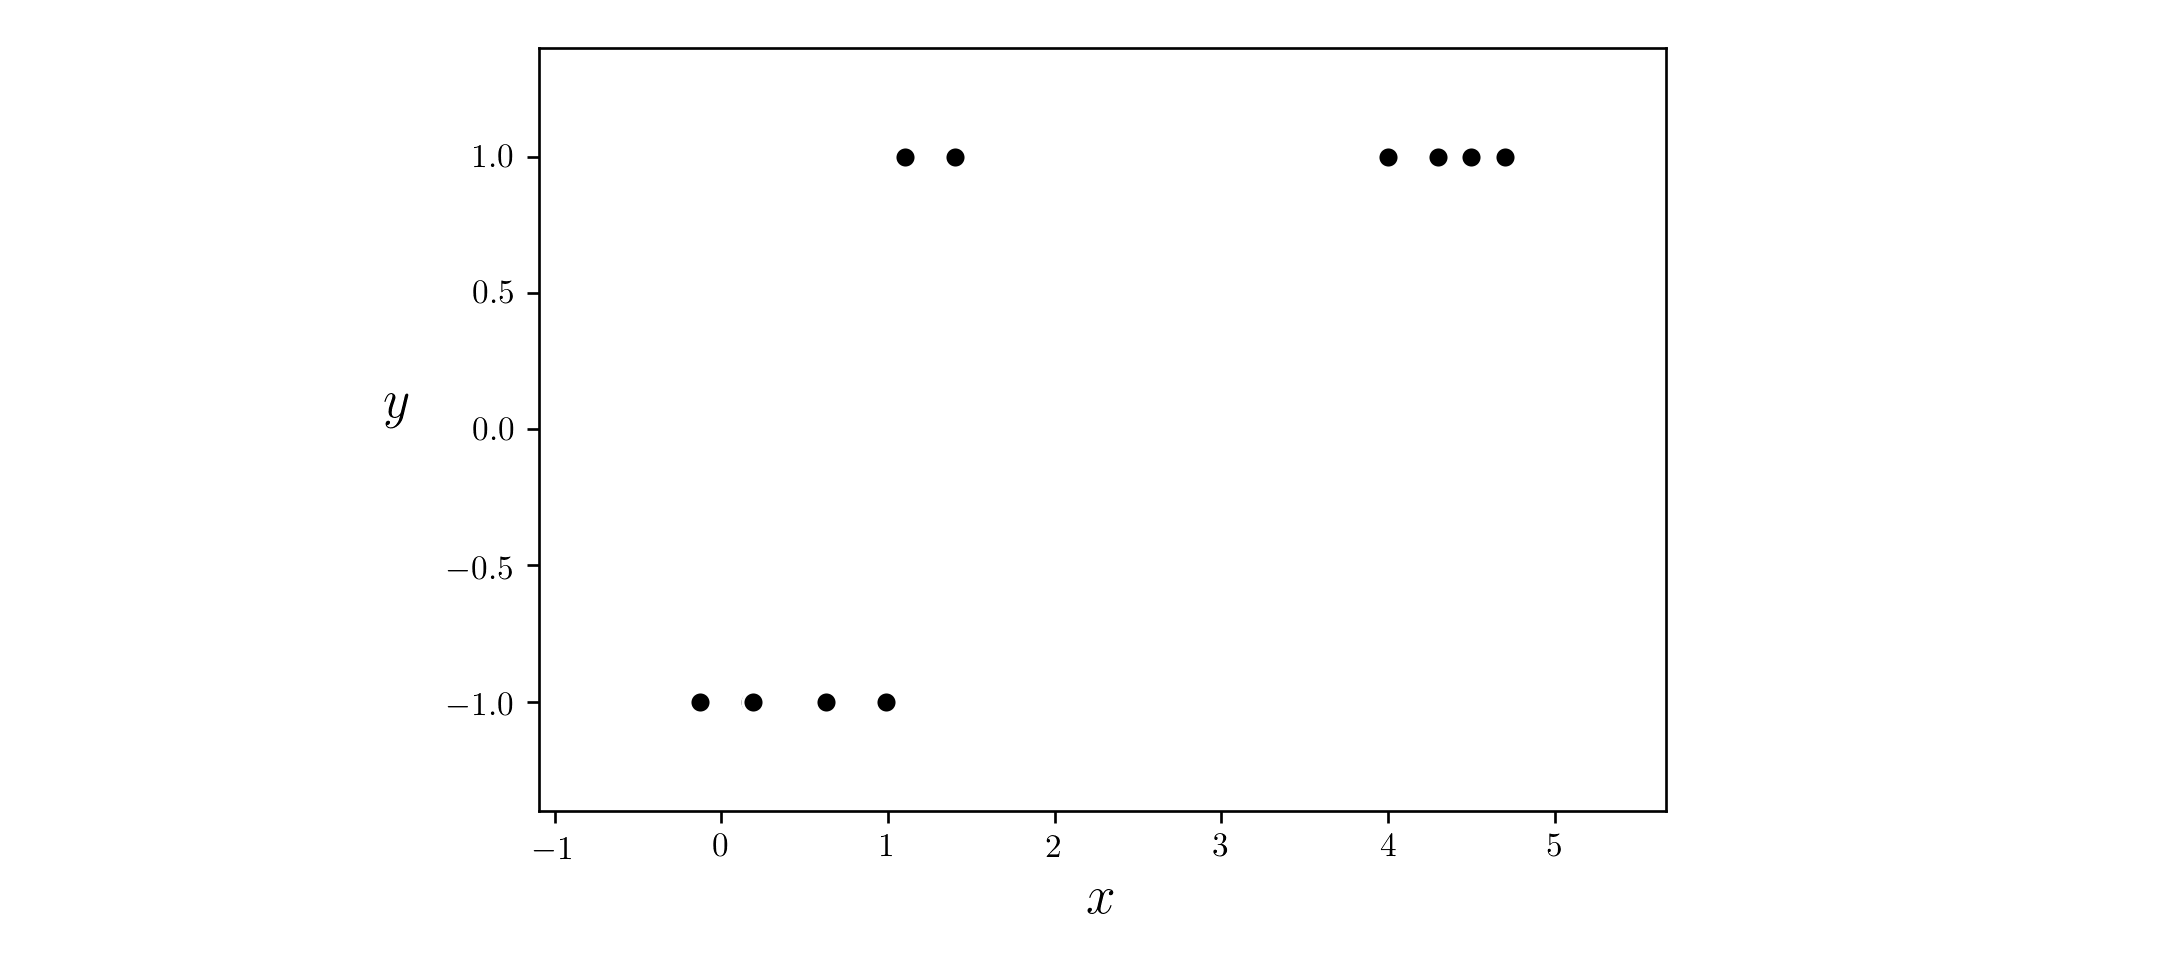

In [4]:
# load data
csvname = sup_datapath + '2d_classification_data_v1.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:] 

# plot dataset
demo = classif_plotter.Visualizer(data)
demo.plot_data()

Here we would use our standard linear model 

\begin{equation}
\text{model}\left(x,\mathbf{w}_{\!}\right) = w_0 + w_1x.
\end{equation}

Although we did not explicitly call it such until this Chapter, here we are employing the simple *linear* feature transformation

\begin{equation}
f\left(x\right) = x
\end{equation}

and in this notation our `model` is then equivalently

\begin{equation}
\text{model}\left(x,\mathbf{w}_{\!}\right) = w_0 + w_{1\,}f\left(x\right).
\end{equation}

This is a rather trivial feature transformation to implement in `Python` - as we do below.

In [5]:
# the trivial linear feature transformation
def feature_transforms(x):      
    return x

Below we perform a run of gradient descent on this dataset - first performing standard normalization on the input as detailed in Section 9.4.  This means (as detailed in the previous Section as well) that we can actually think of the normalization as being a part of the feature transformation itself, and write it formally as

\begin{equation}
f\left(x \right) = \frac{x - \mu}{\sigma}
\end{equation}

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset's input.  There is no need however to adjust the `feature_transforms` implementation to reflect this, since we can construct this version of our feature transformation by composing it with a function `normalizer` function that performs the standard normalization (as detailed in e.g., Section 8.4) as `feature_transforms(normalizer(x))`.

In [19]:
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(2,1); max_its = 500; alpha_choice = 10**(2)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'softmax',normalize = 'standard')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

We can then plot the hyperbolic tangent correspnoding to those weights providing the lowest cost function value during the run, as we do below.  The fit does indeed match the behavior of the dataset well and its linear decision boundary does indeed separate the two classes completely.

<IPython.core.display.Javascript object>


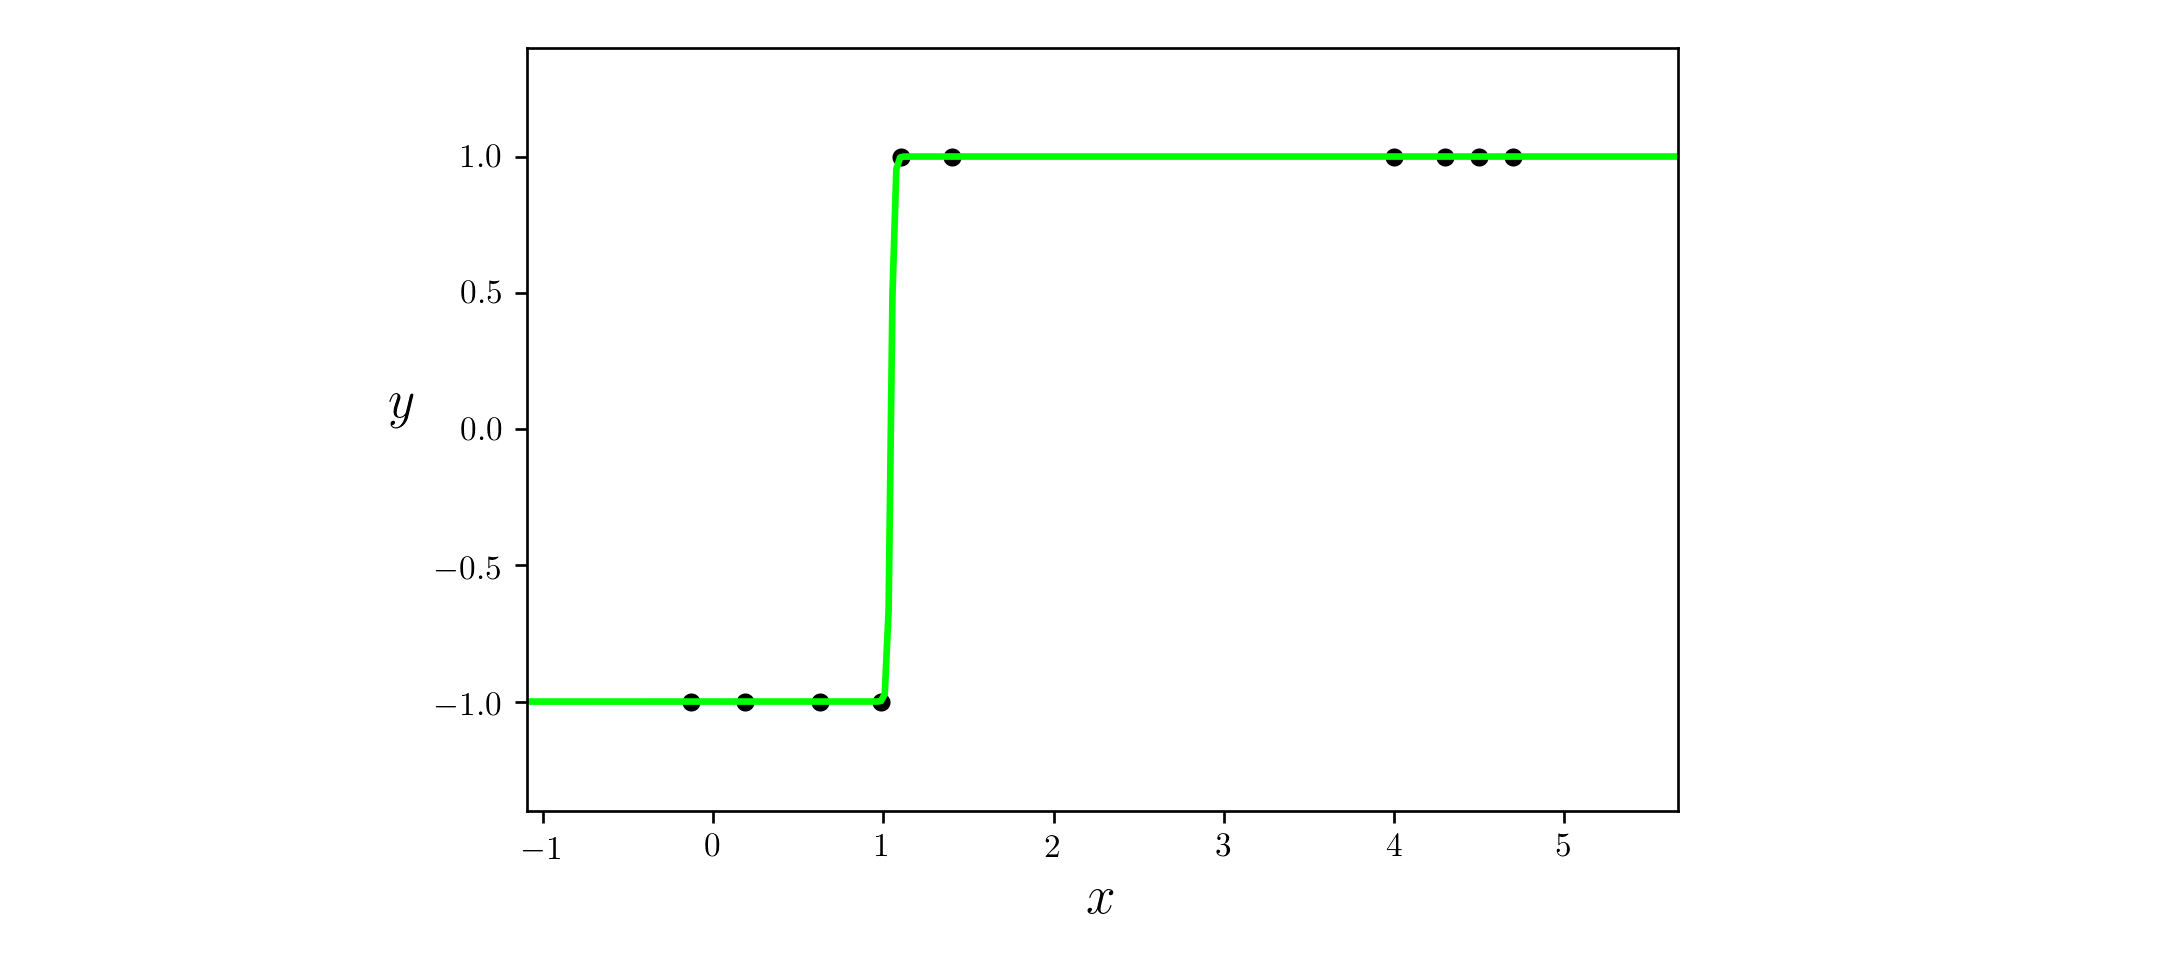

In [21]:
# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.plot_fit(w_best,run.model,normalizer = run.normalizer);

#### <span style="color:#a50e3e;">Example 4. </span> A one dimensional nonlinear example

In discussing classification through the lens of logistic regression in Section 8.1, we saw how linear classification can be thought of as a particular instance of nonlinear regression.  In particular how from this perspective we aim at fitting a curve (or surface in higher dimensions) that consists of a linear combination of our input shoved through the `tanh` function.  For $N=1$ dimensional input this regression looks like

\begin{equation}
\text{tanh}\left(w_0^{\,} + {w}_{1}^{\,}{x}_p\right) \approx y_p.
\end{equation}

Here our `model` is the simple linear one

\begin{equation}
\text{model}(x,\mathbf{w}) =  w_0 +_{\,} w_1x_{\,}.
\end{equation}

With classification this function defines the linear decision boundary - a single point in this instance - where $\text{model}(x,\mathbf{w}) = 0$.  After tuning our weights properly by e.g., minimizing the softmax cost function, this decision boundary provides us with predicted labels for every possible input.  In particular if $\text{model}(x,\mathbf{w}) > 0$ then $x$ assigned to $+1$ class, if $\text{model}(x,\mathbf{w}) < 0$ assigned to $-1$ class.  This is illustrated in the Figure below.  

<figure>
<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/logistic_1d_line.png' width="80%" height="80%" alt=""/>
  </p>
   <figcaption>   
<strong>Figure 3:</strong> <em> 
A prototypical $N = 1$ dimensional input shown from the regression perspective (top panel) and from 'above' (bottom panel) where label values are illustrated as colors (red for $+1$ and blue for $-1$).  A logistic regression fit providing perfect separation is shown in the top panel, along with the input line to `tanh` that defines the decision boundary for this problem (where this line pierces the input space).  Predictions are then made in the future based geometrically on this line / decision boundary, with predicted regions annotated in the bottom panel.
</em>  </figcaption> 
</figure>
</p>

However a linear predictor - a linear decision boundary - is quite inflexible in general and fails to provide good separation even in the simple example below.  Here we clearly need a `model` function that can cross the input space (the x axis) twice at points separated by a large distance - something a line can never do. 

<IPython.core.display.Javascript object>


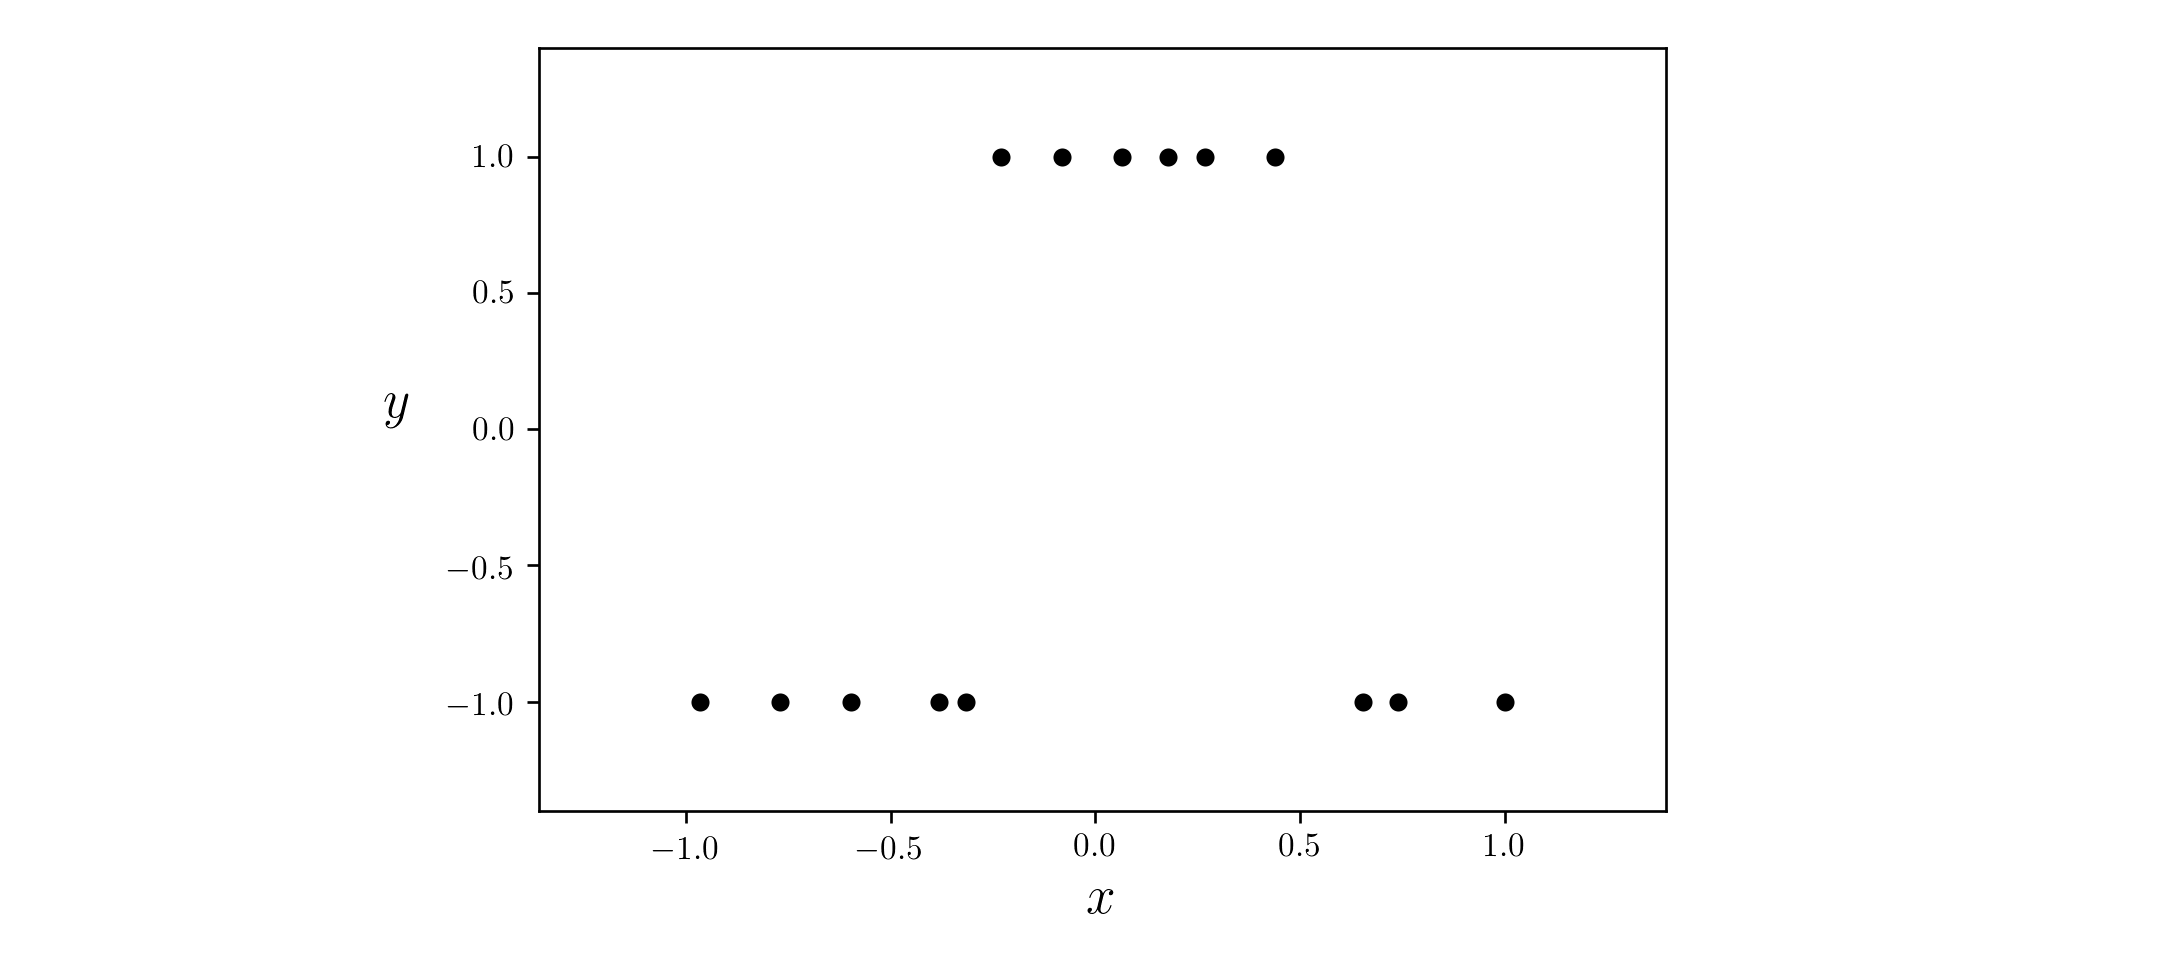

In [23]:
# load data
csvname = datapath + 'signed_projectile.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1].T
y = data[:,-1:] 

# plot dataset
demo = classif_plotter.Visualizer(data)
demo.plot_data()

What sort of simple function crosses the horizontal axis twice?  How about a quadratic function?  If adjusted to the right height a quadratic certainly can be made to cross the horizontal axis twice and - when shoved through a `tanh` - could indeed give us the sort of predictions we desire.  This idea is drawn figuratively for a dataset like the one above in the Figure below, where a dataset like the one we are examinig is shown both from a regression perspective (top panel) and 'from above' where label values are represented by unique colors (bottom panel).

<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/logistic_1d_quadratic.png' width="80%" height="80%" alt=""/>
</p>
<figcaption>   
<strong>Figure 4:</strong> <em> 
An example dataset like the one we are currently looking to learn a classifier on (shown from the regression perspective in the top panel, and 'from above' in the bottom panel).  Here we show what a quadratic model could achieve in terms of providing a proper decision boundary consisting of two distinct and separate points, with the proper regions of the space classified accordingly. 
</em>  </figcaption> 
</figure>
</p>

Using a generic quadratic function as our `model` takes the form

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + w_1x + w_2x^2.
\end{equation}

Notice here how we have 2 feature transformations: the identity $f_1(x) = x$ and the quadratic term $f_2(x) = x^2$, and so we may write the above equivalently as

\begin{equation}
\text{model}(x,\mathbf{w}) = w_0 + w_1\,f_1(x) + w_2\,f_2(x)
\end{equation}

As we saw with nonlinear regression in the previous Section, while we think of this predictor as providing a *nonlinear* separation in the original space it is indeed linear in the features themselves.  Hence - as we will see - while it provides a *nonlinear* separation in the original space it will simultaneously provide a *linear* fit in the *transformed feature space* - that is the space whose input axes are defined via these features.

But first we need to implement our feature transformations and `model` - which we do below.  Notice how this is precisely the same feature transformation and `model` used in Example 5 of the previous Section.

In [38]:
# our quadratic feature transformation
def feature_transforms(x):
    # calculate feature transform
    f = np.array([(x.flatten()**d) for d in range(1,3)])   
    return f

We will then tune our parameters via gradient descent, and to speed up its convergence we will apply *standard normalization* (as discussed in Section 9.4) to the input of the data.  We can then think about each of our feature transformations involving this normalization as $f_1(x) = \frac{x - \mu}{\sigma}$ and the quadratic term $f_2(x) = \left(\frac{x - \mu}{\sigma}\right)^2$ where $\mu$ and $\sigma$ are the mean and standard deviation of the input data, which we accomplish by feeding normalized input into each.

In [41]:
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(3,1); max_its = 500; alpha_choice = 10**(2)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'softmax',normalize = 'standard')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

With our weights tuned and our predictor trained we can then plot the resulting fit / separation.  In the left panel we show the original dataset - from the regression perspective-  along with the nonlinear fit provided by our nonlinear logistic regressor $\text{tanh}\left(\text{model}\left(x, \mathbf{w}\right)\right) = y$.  In the right panel we show the same dataset only in the transformed feature space defined by our two features.  Here a datapoint that originally had input $x_p$ now has input $\left(f_1\left(x_p\right)\,,(f_2\left(x_p\right)\right)$.  In this space the separation / decision boundary is *linear*.

<IPython.core.display.Javascript object>


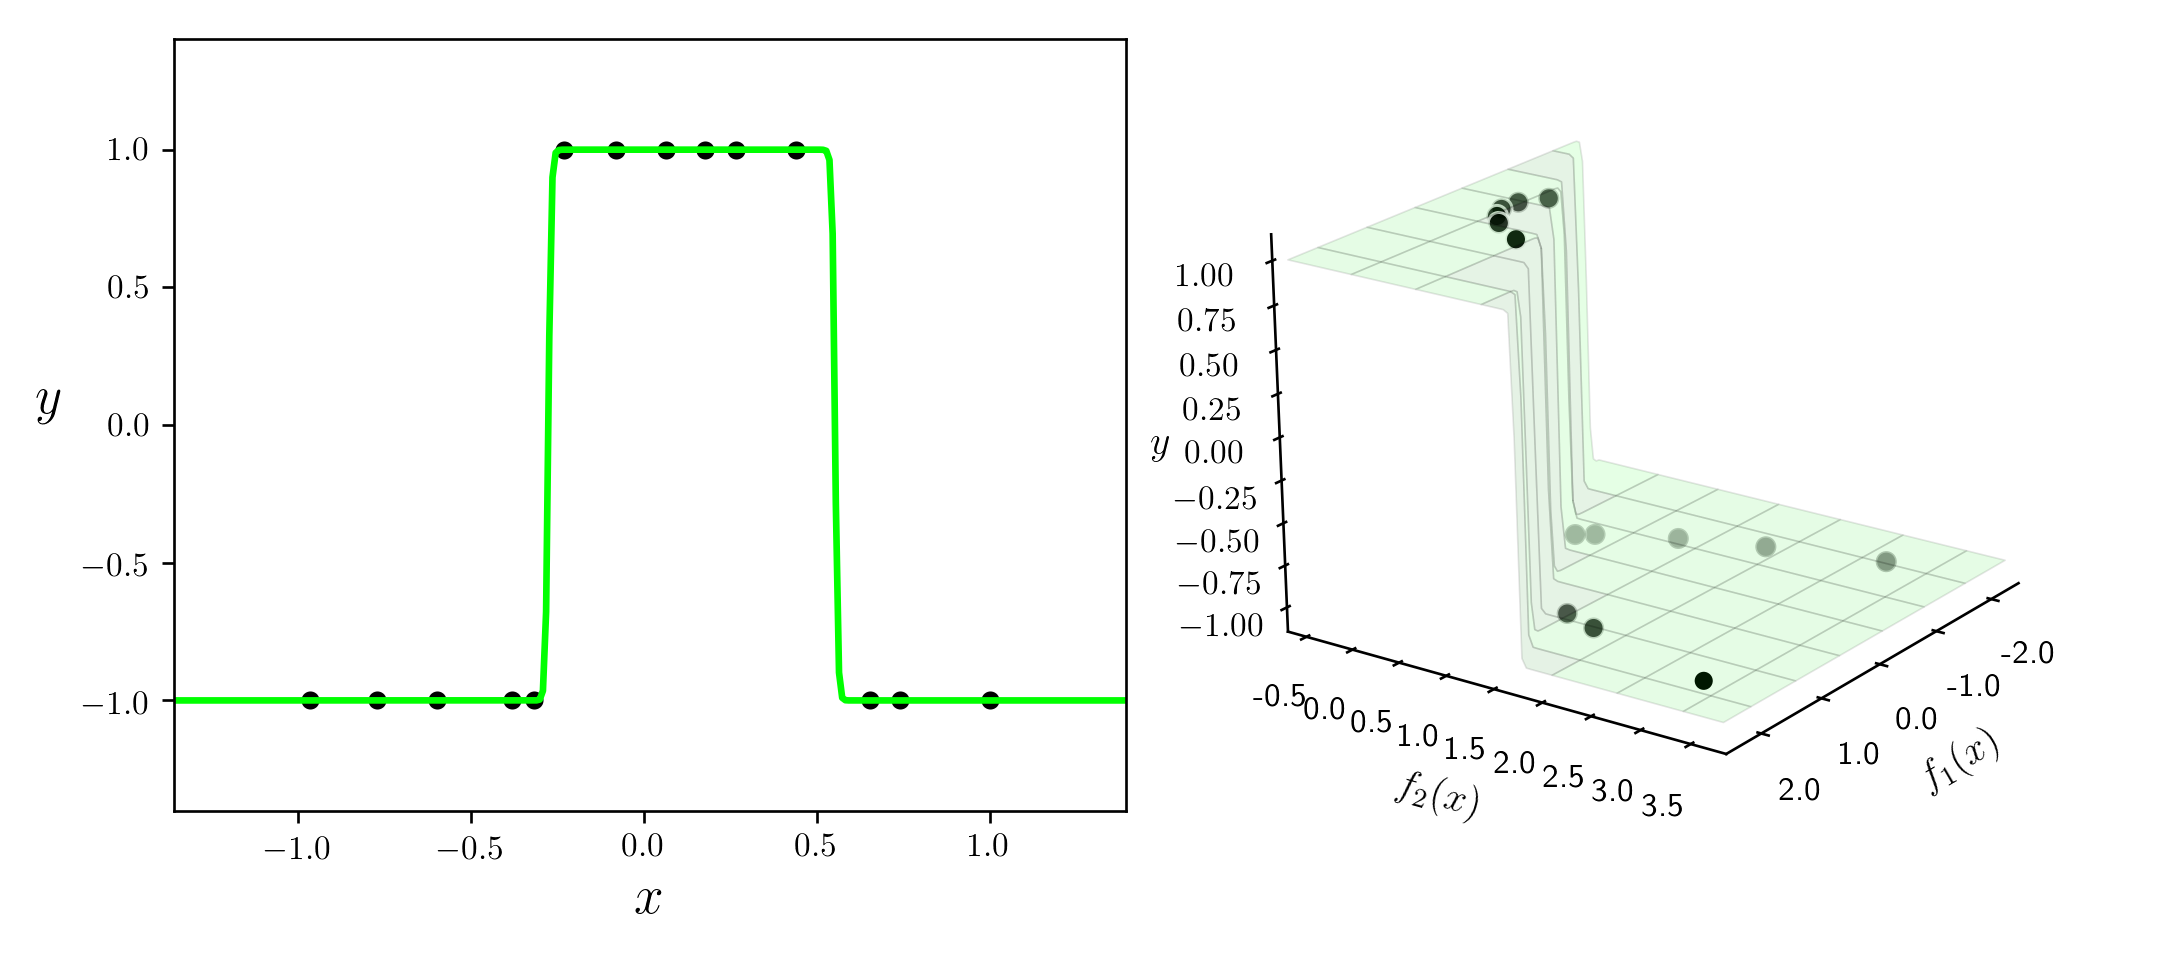

In [44]:
# plot data and fit in original and feature transformed space
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.plot_fit_and_feature_space(w_best,run.model,run.feature_transforms,normalizer = run.normalizer,view = [25,35])

What we see with this example - a nonlinear decision boundary in the original space being simultaneously *linear* in the transformed feature space - always happens in practice if we have chosen our features well (i.e., as to provide a good nonlinear decision boundary in the original space).  

> Properly designed features provide good nonlinear separation in the original feature space and, simultaneously, good linear separation in the transformed feature space.

Also notice here that since we have used two features our feature space is one dimension larger than the original space.  As was the case with regression this is true more generally speaking: the more feature transforms we use the higher the up we go in terms of the dimensions of our transformed feature space / linear separation!  In general if our original input has dimension $N$ - and is written as $\mathbf{x}$ - and we use a `model` function that employs $B$ nonlinear feature transformations as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + {w}_{1}\,f_1\left(\mathbf{x}\right) +  {w}_{2}\,f_2\left(\mathbf{x}\right) + \cdots + w_B\,f_B\left(\mathbf{x}\right)  
\end{equation}

then our original space has $N$ dimensional input, while our transformed feature space is $B$ dimensional.  Note here that the set of all weights $\omega$ contains not only the weights $w_1,\,w_2,...,w_B$ from the linear combination, but also any features's internal parameters as well.

#### <span style="color:#a50e3e;">Example 2. </span> A two-dimensional example

Let us examine the following $N=2$ input dataset below, visualized the regression perspective (left panel) and 'from above' (right panel).

<IPython.core.display.Javascript object>


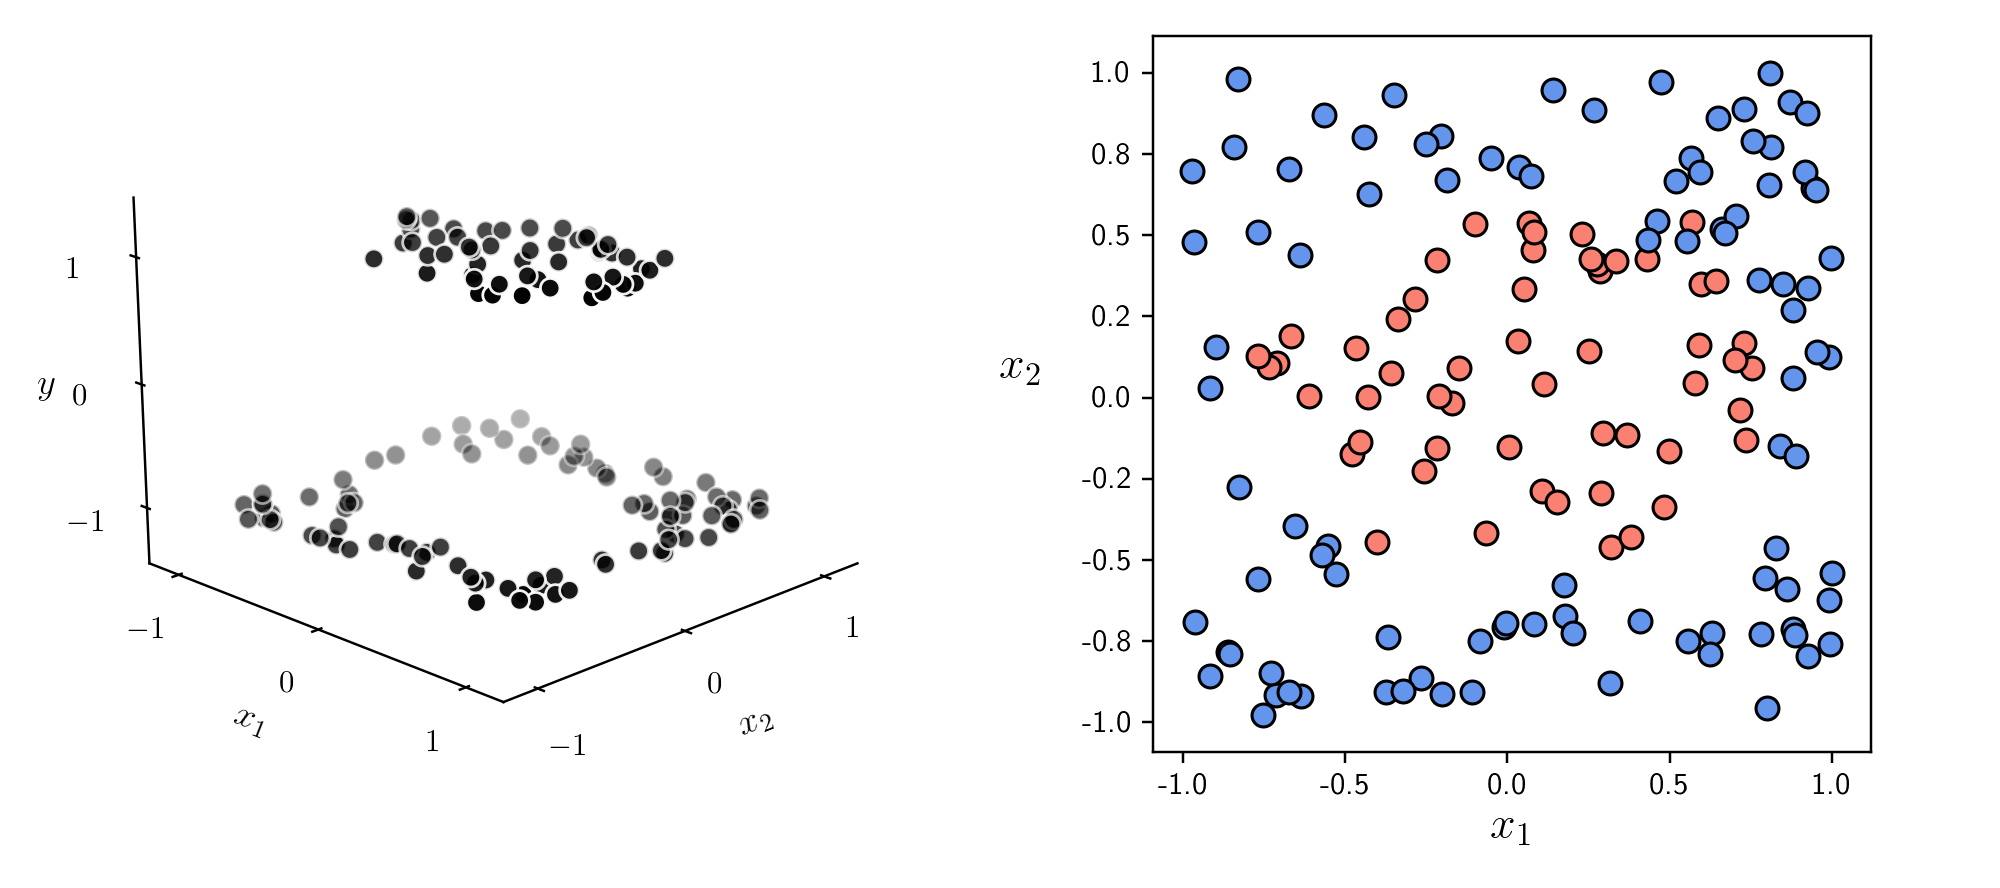

In [2]:
# create instance of linear regression demo, used below and in the next examples
demo = nonlib.nonlinear_classification_visualizer.Visualizer(datapath + 'ellipse_2class_data.csv')
x = demo.x.T
y = demo.y[:,np.newaxis]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo.plot_data();

Visually examining the dataset it appears that some sort of elliptical decision boundary centered at the origin might do a fine job of classification.  Thus we set our `model` function to the general parameterized form of such an ellipse   

\begin{equation}
\text{model}(\mathbf{x},\mathbf{w}) = w_0^{\,} + w_1^{\,} x_1^2 + w_2^{\,}x_2^2.
\end{equation}

Parsing this formula ,we can see that we have used two feature transformations $f_1(\mathbf{x})=x_1^2$ and $f_2(\mathbf{x}) = x_2^2$.  

We write out each feature transformation, the prediction function, and softmax cost in `Python` cell below.  Here we will not normalize, as doing so would mean altering the distribution of the data enough so that the pure elliptical feature transformations we have used (i.e., we have not use any cross terms like $x_1x_2$) would no longer be appropriate.  

In [239]:
# a elliptical feature transformation
def feature_transforms(x):
    # calculate feature transform
    f = x**2  
    return f

And now we minimize the softmax above via gradient descent.

In [245]:
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(3,1); max_its = 200; alpha_choice = 10**(1)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'softmax',normalize = 'none')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

With our weights tuned we can now plot the data in its original space (left panels) - along with the nonlinear decision boundary provided by the trained predictor - and in the transformed feature space (right panels) - where the corresponding decision boundary is linear.  In each panel we color a region of space by what class our predictor assigns it post training.  Indeed our presumption of an elliptical boundary seems like a good one here - as our classification results are quite good.

<IPython.core.display.Javascript object>


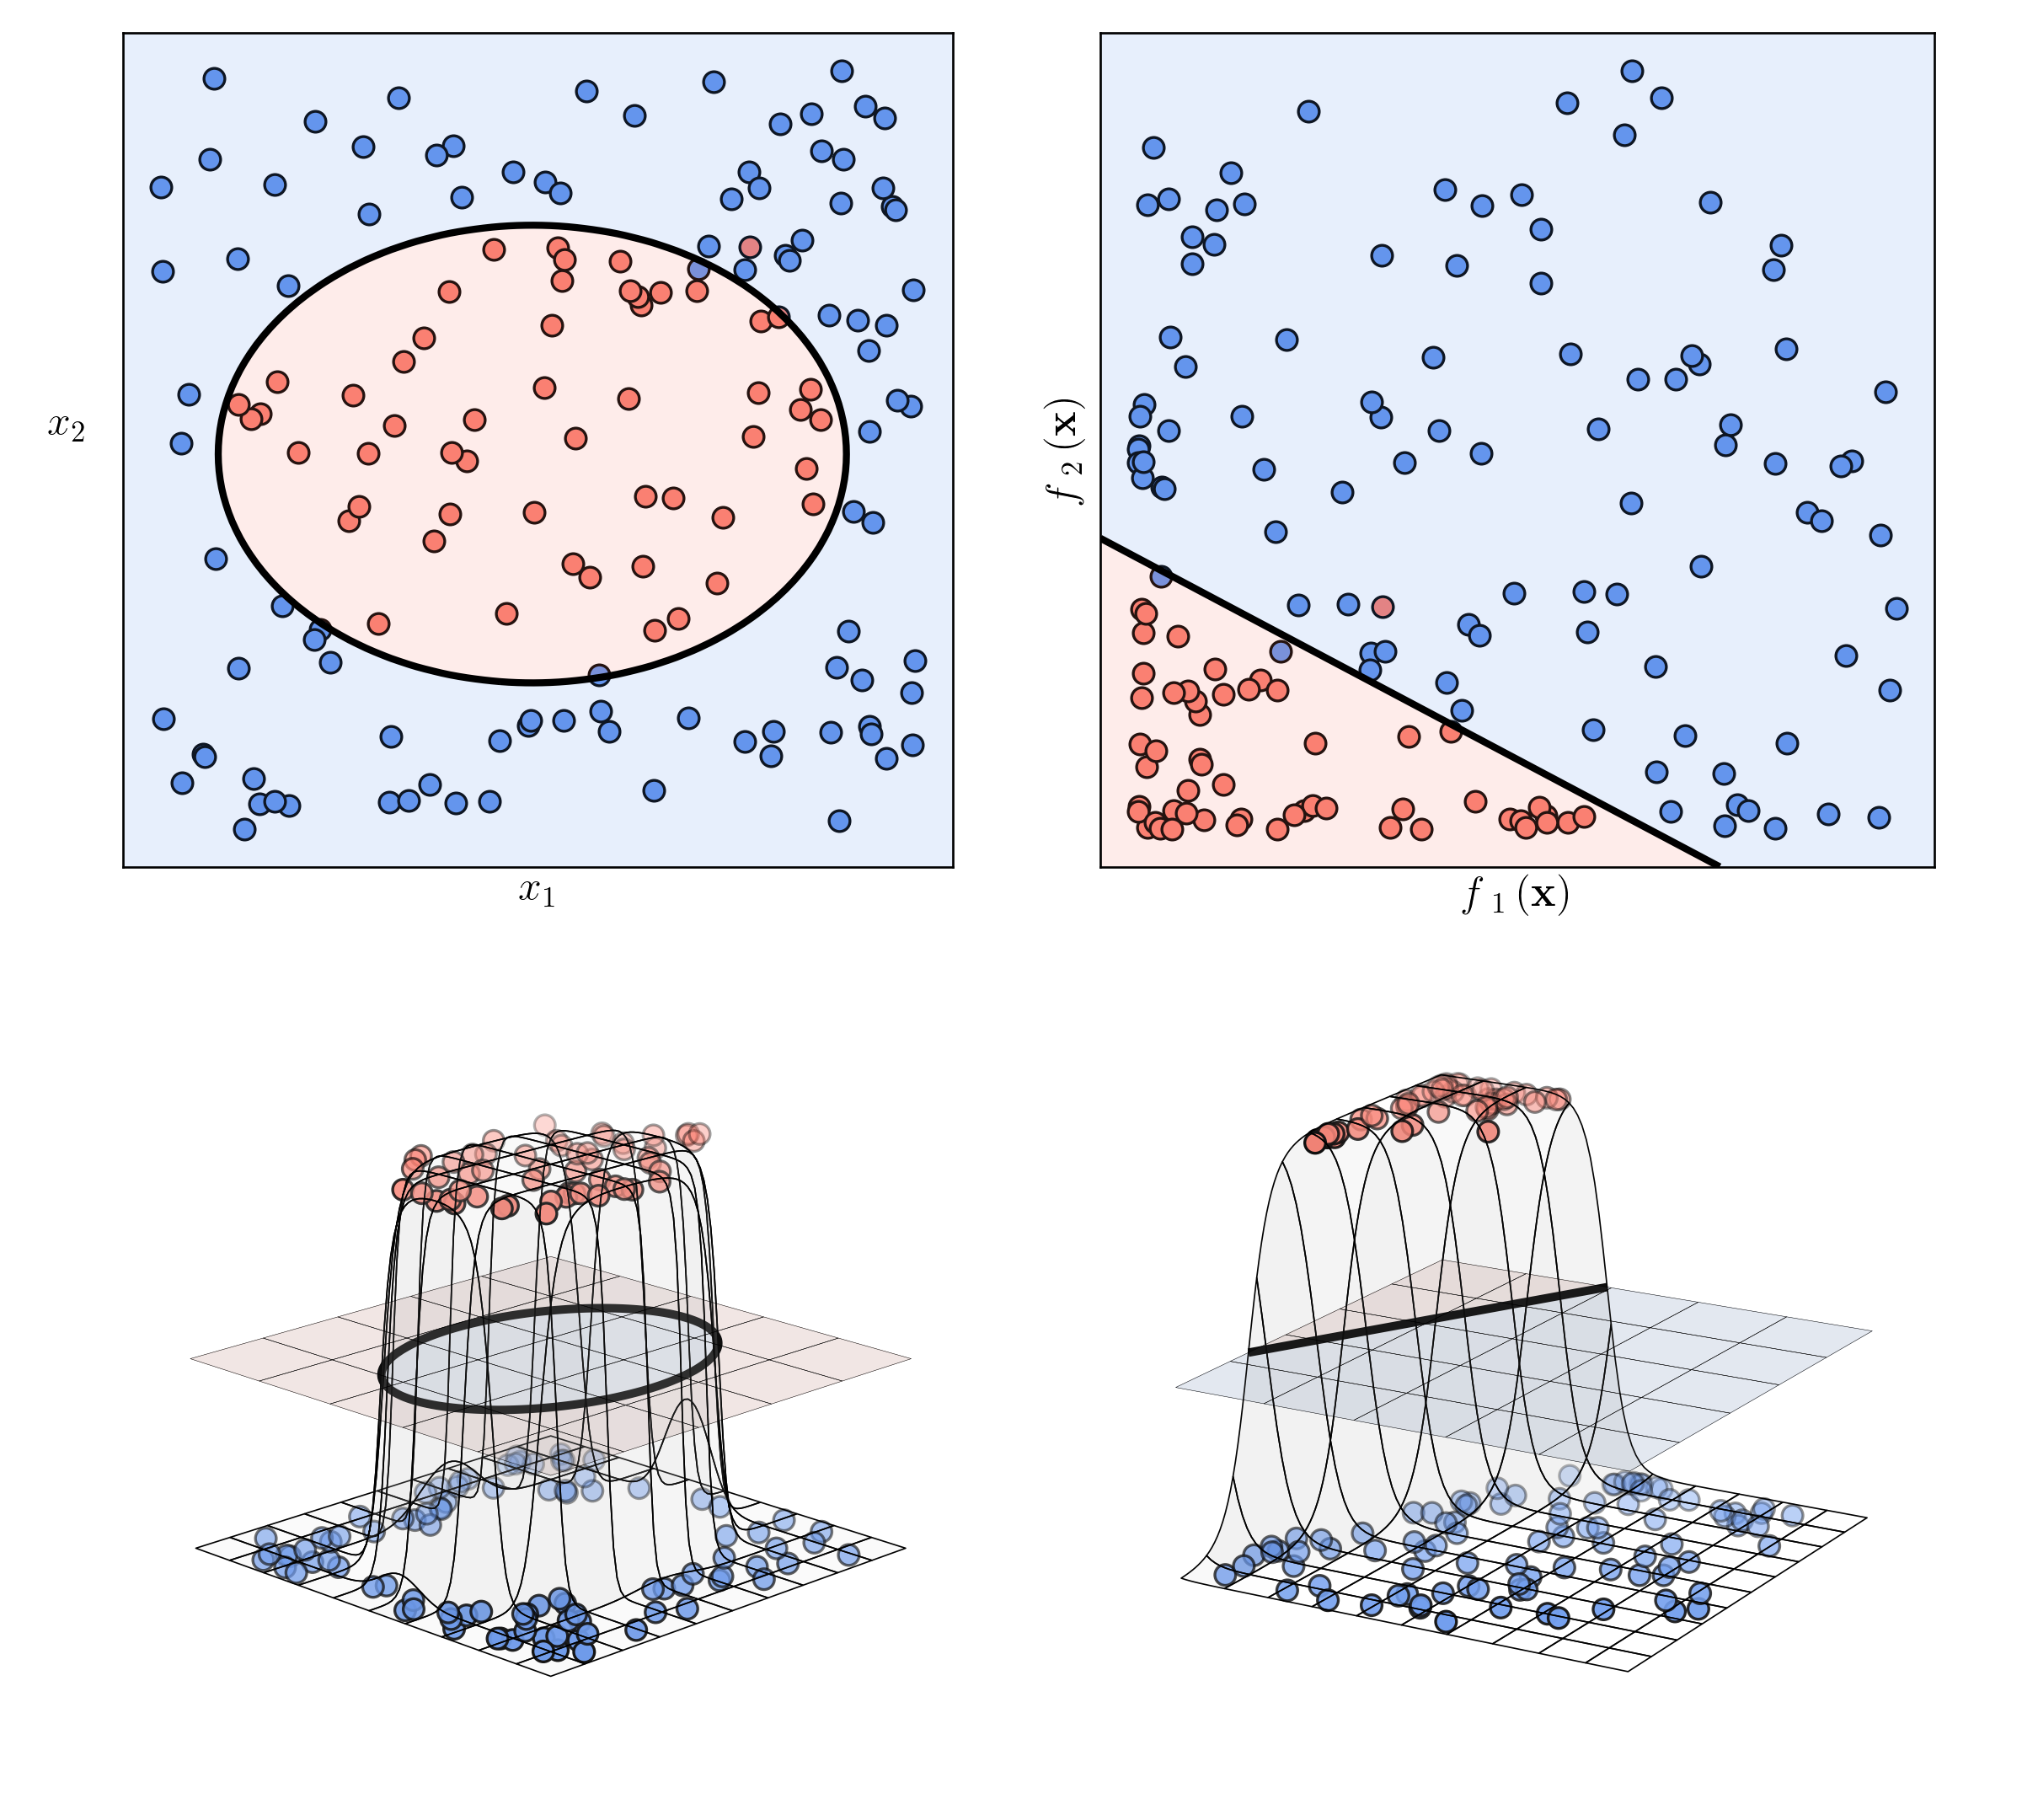

In [246]:
# illustrate results
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.static_N2_img(w_best,run,view1 = [20,45],view2 = [20,30])

## 12.2.3  Modeling principles linear and nonlinear multiclass classification

We can inject nonlinearity into our mulitclass classification in the same way we have done above for two-class scenario, regardless of which approach to multiclass classification we take where $C$ classifiers are to be learned - the One-versus-All or simultaneous multiclass framework detailed in Sections 10.1 and 10.2 respectively.  When introducing these frameworks in Chapter 10 we simply assumed each of these classifiers was *linear*, but just as we did with the two-class case we can go back and simply exchange our linear `model` with a nonlinear one based on nonlinear feature transformations.  

Indeed to extend the linear One-versus-All framework  - which consists of training $C$ two-class classifiers independently - to the nonlinear scenario follows exactly the approach outlined above for each individual classifier.  That is if we denote by $\mathbf{w}^{(j)}$ the entire set of weights of the $j^{th}$ classifier then our original approach - outlined in Section 10.1 - was to tune the weights of a linear model

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right)  = \mathbf{x}^T \mathbf{w}^{(j)}
\end{equation}

 to distinguish class $j$ from all the others.  In other words, in the $j^{th}$ instance we aim at learning a linear decision boundary
 
 \begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathbf{x}^T \mathbf{w}^{(j)} = 0.
\end{equation}

that separates the $j^{th}$ class from all the others as best as possible.  Once trained we can then combine these $C$ nonlinear classifiers by employing the *fusion rule* (introduced in Section 10.1 and discussed further in Section 10.2).     We then use the fusion rule to properly combine these classifiers, producing for each input $\mathbf{x}$ an appropriate label $y$ as

\begin{equation}
y = \underset{j \,=\, 0,...,C-1} {\text{max}}\,\text{model}\left(\mathbf{x},\mathbf{w}^{(j)}\right).
\end{equation}

To translate this to the nonlinear case we use the same fusion rule but for each $j$ we swap out our linear model with one constructed precisely as detailed in the subsections above as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}^{(j)}\right) = w_0^{(j)} + {w}_{1}^{(j)}\,f_1^{(j)}\left(\mathbf{x}_p\right) +  {w}_{2}^{(j)}\,f_2^{(j)}\left(\mathbf{x}_p\right) + \cdots + w_B^{(j)}\,f_B^{(j)}\left(\mathbf{x}_p\right)  
\end{equation}

where $f_1^{(j)},\,f_2^{(j)},\,...\,f_B^{(j)}$ are nonlinear feature transformations chosen for the $j^{th}$ classifier and $w_0^{(j)}$ through $w_B^{(j)}$ - as well as any weights internal to the nonlinear functions - are represented in the weight set $\mathbf{w}^{(j)}$.  

To extend the simultaneous multiclass classifiers (the multiclass perceptron and softmax) we follow the same procedure to extend each classifier, swapping out a linear for nonlinear model constructed as a weighted combination of nonlinear feature transformations.  For example, the multiclass softmax cost function using a generic linear or nonlinear `model` can be written as

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p = 1}^P \left[\text{log}\left( \sum_{j = 0}^{C-1}  e^{ \text{model}\left(\mathbf{x},\mathbf{w}^{(j)}\right)}  \right) - \text{model}\left(\mathbf{x},\mathbf{w}^{(y_p)}\right)\right]
\end{equation}

where the term $\mathbf{w}$ left of the equal sign here denotes the entire set of weights of all $C$ classifiers and again each `model` is built however one desires.   Again when each `model` is linear we have the linear multiclass scheme detailed in Section 10.2.

## 12.2.4  Simple examples of nonlinear  multiclass classification

As we see above, to extend both One-versus-All and the simultaneous multiclass classifiers to the nonlinear setting we can employ the `model` framework used previously for the nonlinear two-class extension.  Because the mathematical modeling so closely resembles the two-class case, the `Python` implementation mirrors closely as well.   In particular we can use the same `model` code-block (just as we also saw in the linear instances of two-class and multiclass classification) - which is repeated below for convenience.  Moreover - just as with the two-class case - here irregardless of the mutliclass approach taken we will be entirely concerned with how to design and translate nonlinear feature transformations into the `Python` implementation function `feature_transforms`.

In [ ]:
# an implementation of our model employing a nonlinear feature 
# transformations which we now use for the multiclass instance
def model(x,w):    
    # feature transformation 
    f = feature_transforms(x,w[0])
    
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(f)[1]))
    f = np.vstack((o,f))
    
    # compute linear combination and return
    a = np.dot(f.T,w[1])
    return a

Every other part of the implementation - i.e., the implementation of the fusion rule for One-versus-All and the multiclass perceptron / softmax cost functions - remains entirely the same as was described in Chapter 10.  However just as with our usage of the `model` function  moving from two-class to multiclass linear instances, in our current  multiclass context we will be inputting different sized objects into the `model` function above than was done in the two-class case (in particular here we will be inputting many more weights than we did previously) and we will be computing feature transformations for all $C$ classifiers in the module `feature_transforms`.  Below we describe  these differences.


Supposing for simplicity that we use a sum of the same $B$ nonlinear feature transformations for each classifier - which is often the case in practice even if for each classifier the transformations use different internal weights (i.e., like a neural network) - we can denote by $\mathbf{f}^{(j)}$ the compactly written vector of feature transformations used by the $j^{th}$ classifier for an input $\mathbf{x}$ topped with a $1$ to deal with the corresponding bias weight as 

\begin{equation}
\mathbf{f}^{(j)} =
\begin{bmatrix}
1 \\
f^{(j)}_1\left(\mathbf{x}\right) \\
f^{(j)}_2\left(\mathbf{x}\right) \\
\vdots \\
f^{(j)}_B\left(\mathbf{x}\right) \\
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathbf{w}^{(j)}=
\begin{bmatrix}
w^{(j)}_0 \\
w^{(j)}_1\left(\mathbf{x}\right) \\
w^{(j)}_2\left(\mathbf{x}\right) \\
\vdots \\
w^{(j)}_B\left(\mathbf{x}\right) \\
\end{bmatrix}
\end{equation}

and corresponding the general nonlinear `model` shown in equation (18) 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}^{(j)}\right) = {\mathbf{f}^{(j)}}^T \mathbf{w}^{(j)}.
\end{equation}

Likewise we can denote $\mathbf{f}^{(j)}_p$ the $j^{th}$ classifier's nonlinear feature transformations of the $p^{th}$ training point $\mathbf{x}_p$ and the corresponding `model` evaluation $\text{model}\left(\mathbf{x}_p,\mathbf{w}^{(j)}\right) = {\mathbf{f}_p^{(j)}}^T \mathbf{w}^{(j)}$.

Forming a single $\left(B+1\right) \times C$ array of weights from each final summation as

\begin{equation}
\mathbf{W}=\left[\begin{array}{cccc}
w_{0}^{(0)} & w_{0}^{(2)} & \cdots & w_{0}^{(C-1)}\\
w_{1}^{(0)} & w_{1}^{(2)} & \cdots & w_{1}^{(C-1)}\\
\vdots & \vdots & \cdots & \vdots \,\,\,\,\,\, \\
w_{B}^{(0)} & w_{B}^{(2)} & \cdots & w_{B}^{(C-1)}\\
\end{array}\right]
\end{equation}

we can then write the evaluation over all $C$ nonlinear models compactly as the $1 \times C$ vector of nonlinear models

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{W}\right) =
\begin{bmatrix}
 {\mathbf{f}^{(0)}}^T \mathbf{w}^{(0)}  \, ,
{\mathbf{f}^{(1)}}^T \mathbf{w}^{(1)}\, ,
\cdots \, ,
{\mathbf{f}^{(C-1)}}^T \mathbf{w}^{(C-1)}
\end{bmatrix}.
\end{equation}

Now we can link this formulae back to the standard `model` implementation above, noting all that is computed in each step of the evaluation.  

``f = feature_transforms(x,w[0])`` - here nonlinear feature transformations for all $C$ classifiers are computed for input an input (or set of inputs) `x` as $\mathbf{f}^{(0)}, \, \mathbf{f}^{(1)},...,\mathbf{f}^{(C-1)}$, the input to the function `w[0]` denotes the entire set of (possible) inputs into these functions

``a = np.dot(f.T,w[1])`` - the final linear combination of the computed features is performed, where `w[1]` denotes the weight matrix $\mathbf{W}$

#### <span style="color:#a50e3e;">Example 3. </span>  Nonlinear One-versus-All multiclass classification

In this example we use perform One-versus-All multiclass classification on the dataset shown below, which consists of $C=3$ classes that appear to be separable by elliptical boundaries. 

<IPython.core.display.Javascript object>


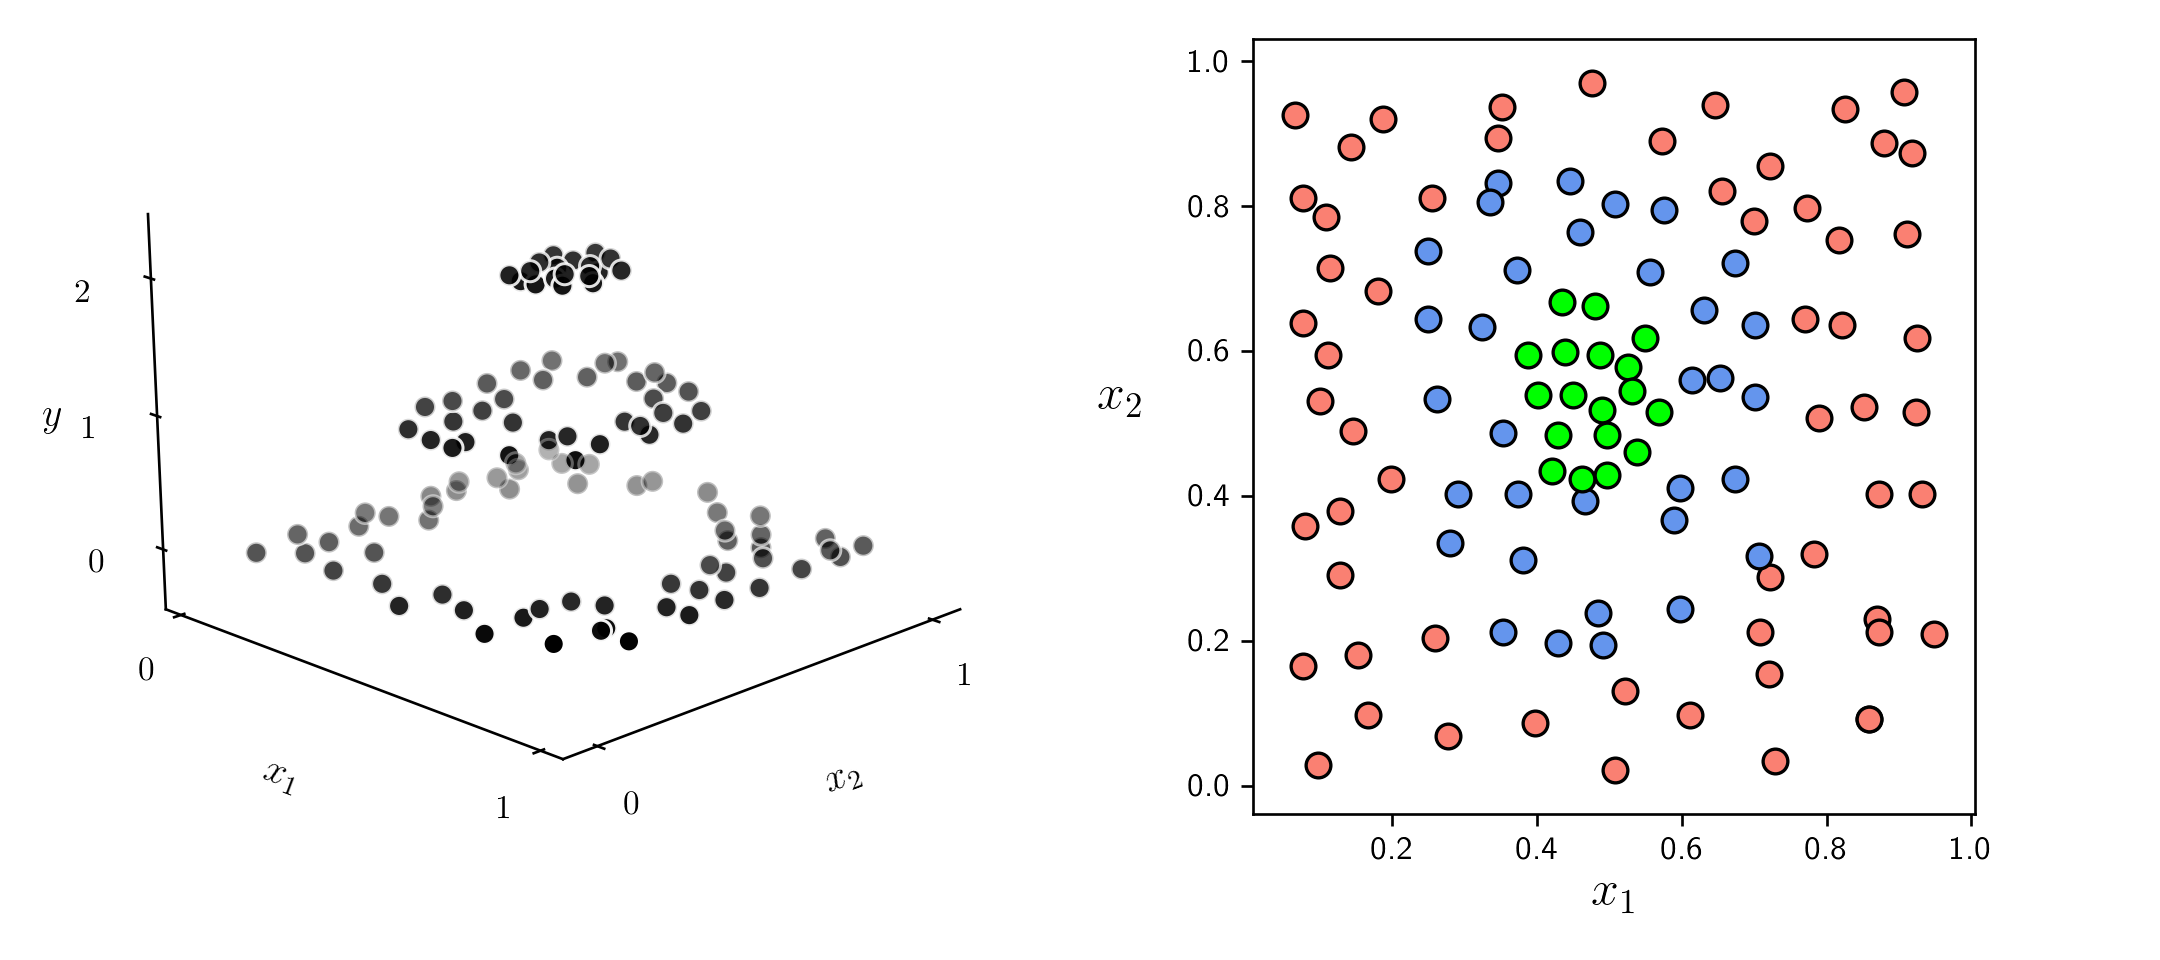

In [2]:
# create instance of linear regression demo, used below and in the next examples
demo = nonlib.nonlinear_classification_visualizer.Visualizer(datapath + '3_layercake_data.csv')
x = demo.x.T
y = demo.y[:,np.newaxis]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
demo.plot_data();

While it looks like the classes of this dataset can be cleanly separated via elliptical boundaries, the distribution of each class is not centered at the origin (as was the case in the previous example).  This means that, in order to properly determine these elliptical boundaries, we cannot just use pure quadratic terms in each input dimension (as was done in the previous example).  Here to capture this behavior we will use a full degree 2 polynomial expansion of the input.  Terms from a general degree $D$ polynomial always take the form

\begin{equation}
f\left(\mathbf{x}\right) = x_1^ix_2^j
\end{equation}

where $i + j \leq D$.  To employ all of them for $D = 2$ means using the following nonlinear model

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + w_1x_1 + w_2x_2 + w_3x_1x_2 + w_4x_1^2 + w_5x_2^2
\end{equation}

where each term in usage (besides the bias $w_0$) is a feature transformation.

In `Python` we can implement this in a `feature_transforms` as follows.

In [40]:
# a elliptical feature transformation
def feature_transforms(x):
    # calculate feature transform
    f = []
    for i in range(0,D):
        for j in range(0,D-i):
            if i > 0 or j > 0:
                term = (x[0,:]**i)*((x[1,:])**j)
                f.append(term)
    return np.array(f)

We will standard normalize our input prior to optimization, hence with each feature transformation we treat  $x_1 \longleftarrow \frac{x_1 -  \mu_1}{\sigma_1}$ and $x_2 \longleftarrow \frac{x_2 -  \mu_2}{\sigma_2}$ where $\mu_1$ /$sigma_1$ and $\mu_2$ / $sigma_2$ are the means / standard deviations of the data along the $x_1$ and $x_2$ input dimensions.  Below we solve the $C$ two class problems (via minimizing the softmax cost) using the above feature transformation using $1,500$ gradient descent steps, $\alpha = 1$ for each run, and the same random initialization for each run. 

In [51]:
# run one versus all
max_its = 1500; alpha_choice = 10**(0); w = 0.1*np.random.randn(6,1)
combined_weights, count_history = nonlib.one_versus_all.train(x,y,feature_transforms,alpha_choice = alpha_choice,max_its = max_its,w = w)

Now we plot each resulting two-class classifier (top row below), as well as the combined results determined by the fusion rule both from a regression perspective (bottom left panel) and from 'above' (in the right panel).  Here we were able to achieve perfect classification.

<IPython.core.display.Javascript object>


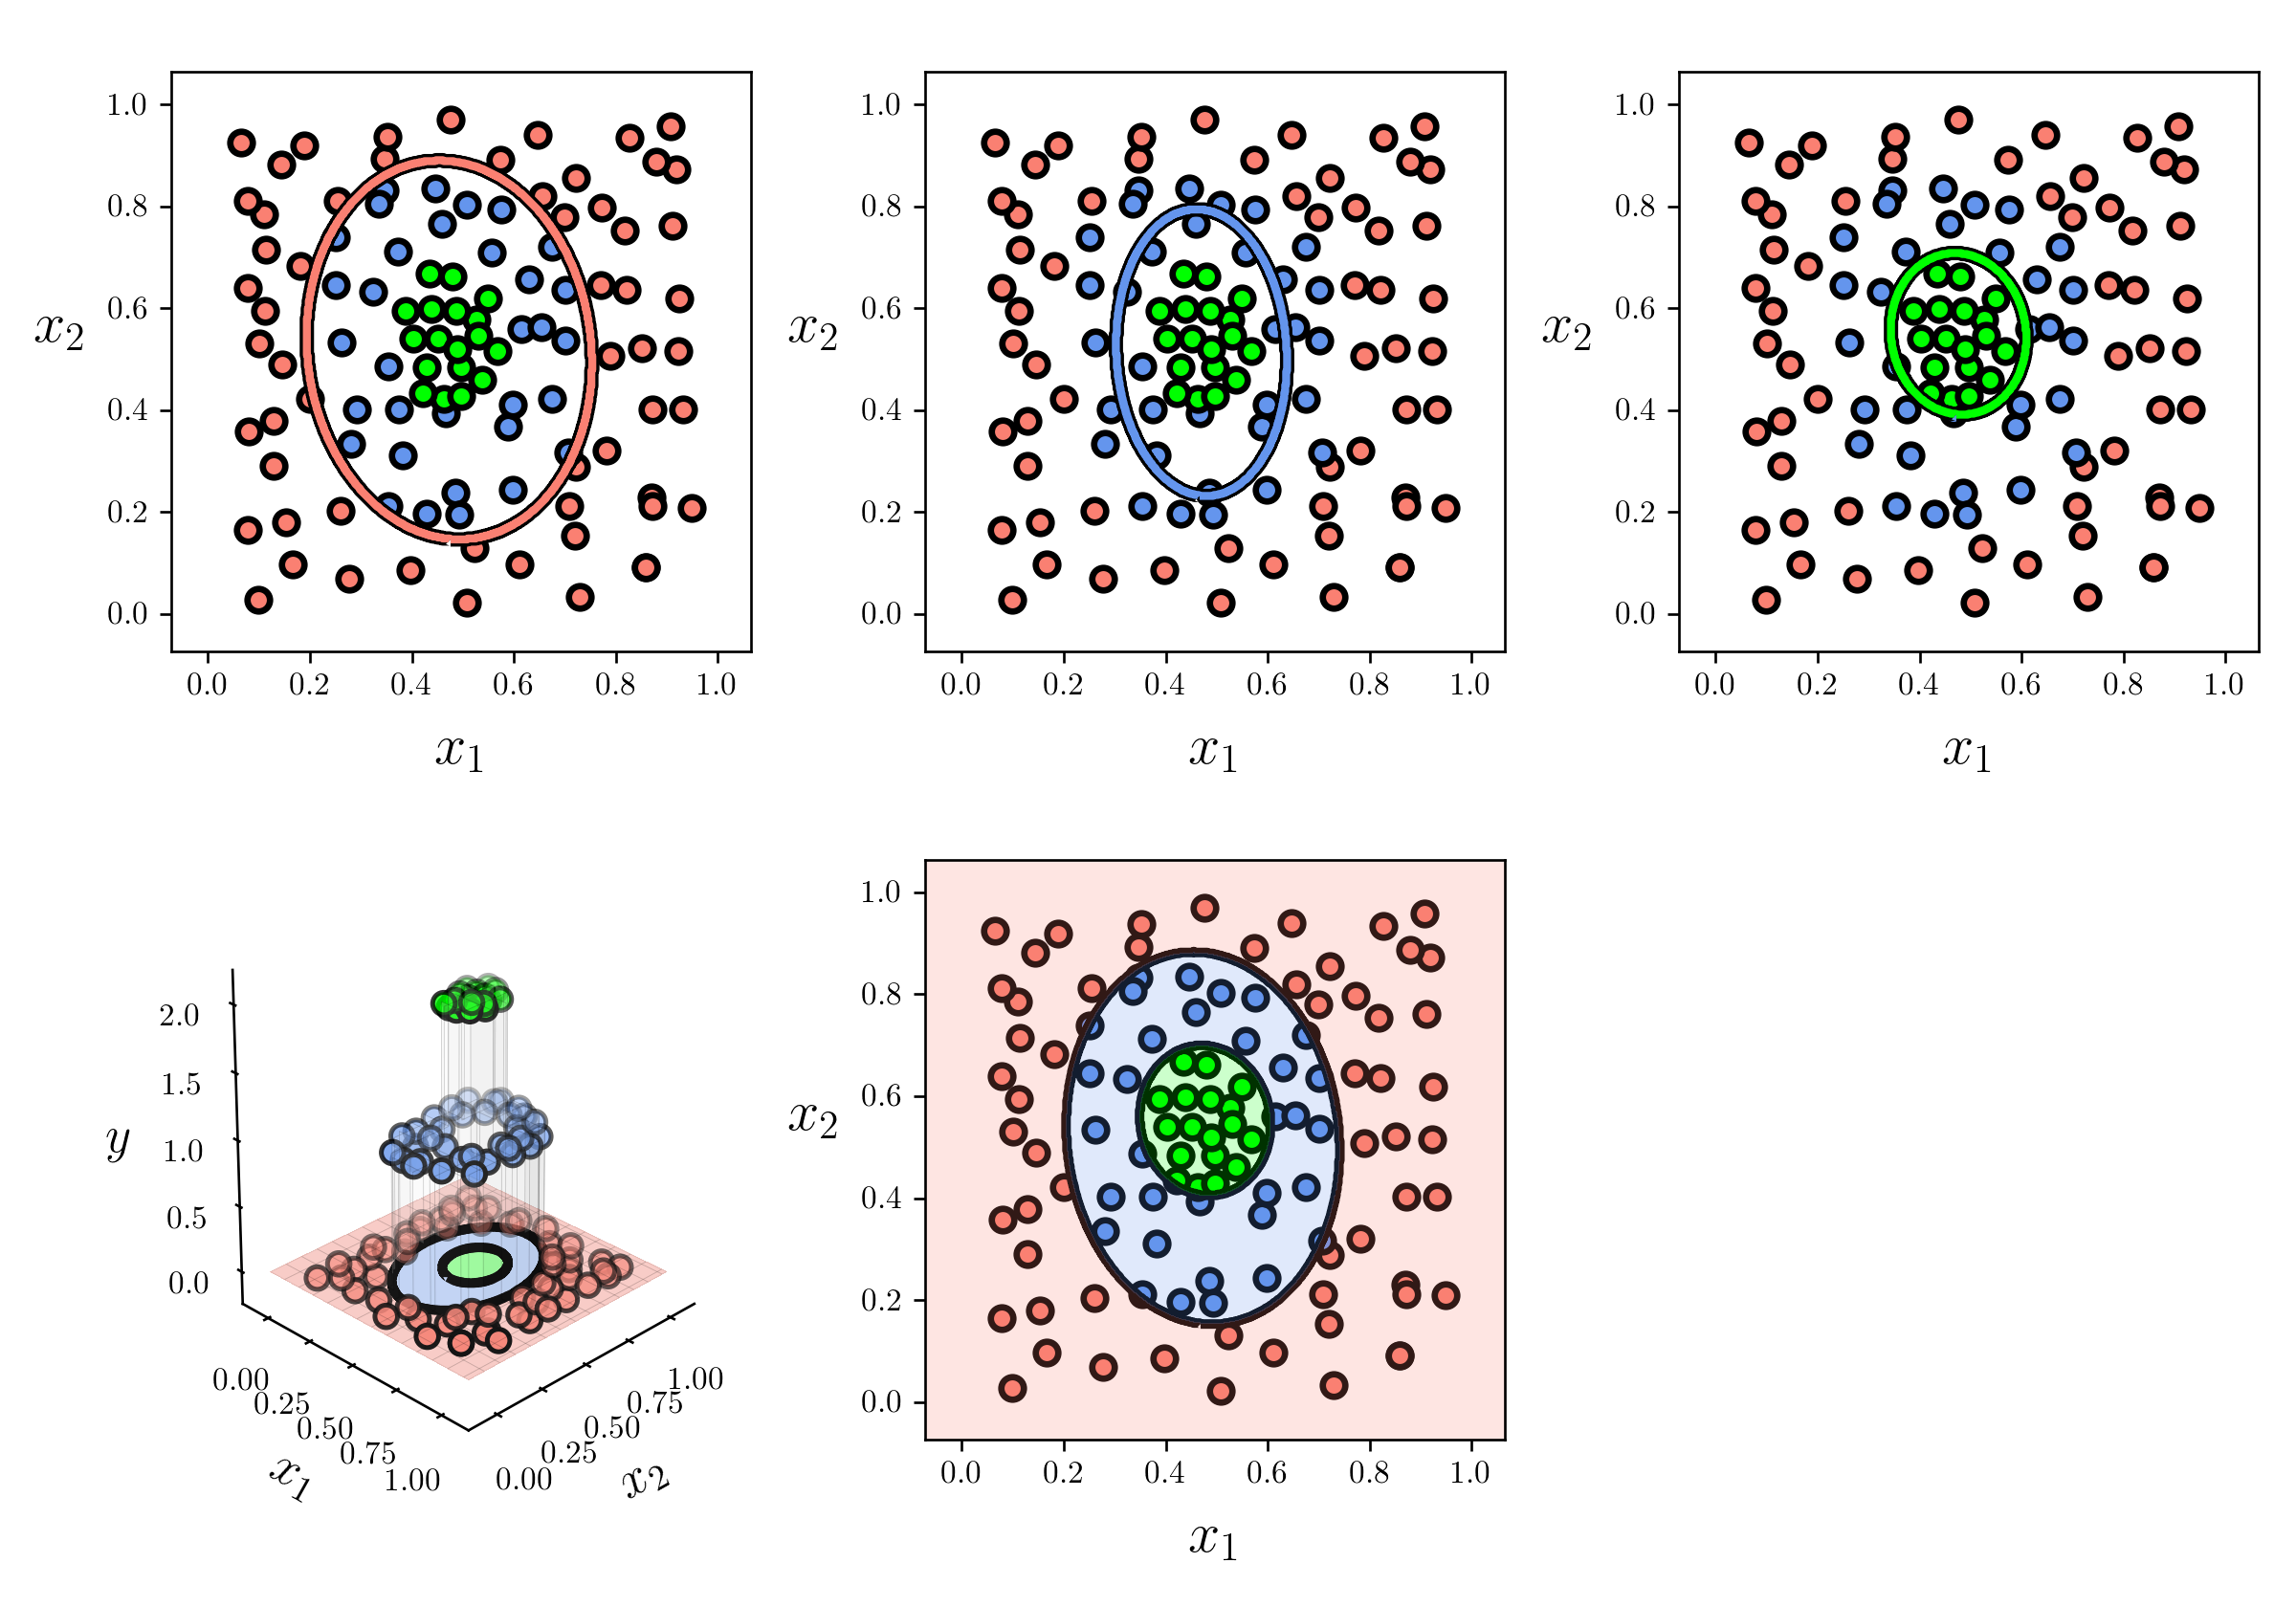

In [42]:
# draw resulting nonlinear boundaries for each classification problem, as well as the
# entire multiclass boundary
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'multiclass_counter',normalize = 'standard')
w_best = combined_weights[-1]
demo.show_individual_classifiers(run,w_best)

#### <span style="color:#a50e3e;">Example 4. </span>  Nonlinear multiclass softmax classification

Here we repeat the same experiment on the same dataset discussed in the previous example, only now use the multiclass softmax cost function to perform classification simultaneously.  In particular, this means we use the same `feature_transforms` function, perform standard normalization prior to optimization, etc.,

In [47]:
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(6,3); max_its = 1500; alpha_choice = 10**(0)

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'multiclass_softmax',normalize = 'standard')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

Here we achieve just as solid results as when using the nonlinear One-versus-All framework in the previous example.

<IPython.core.display.Javascript object>


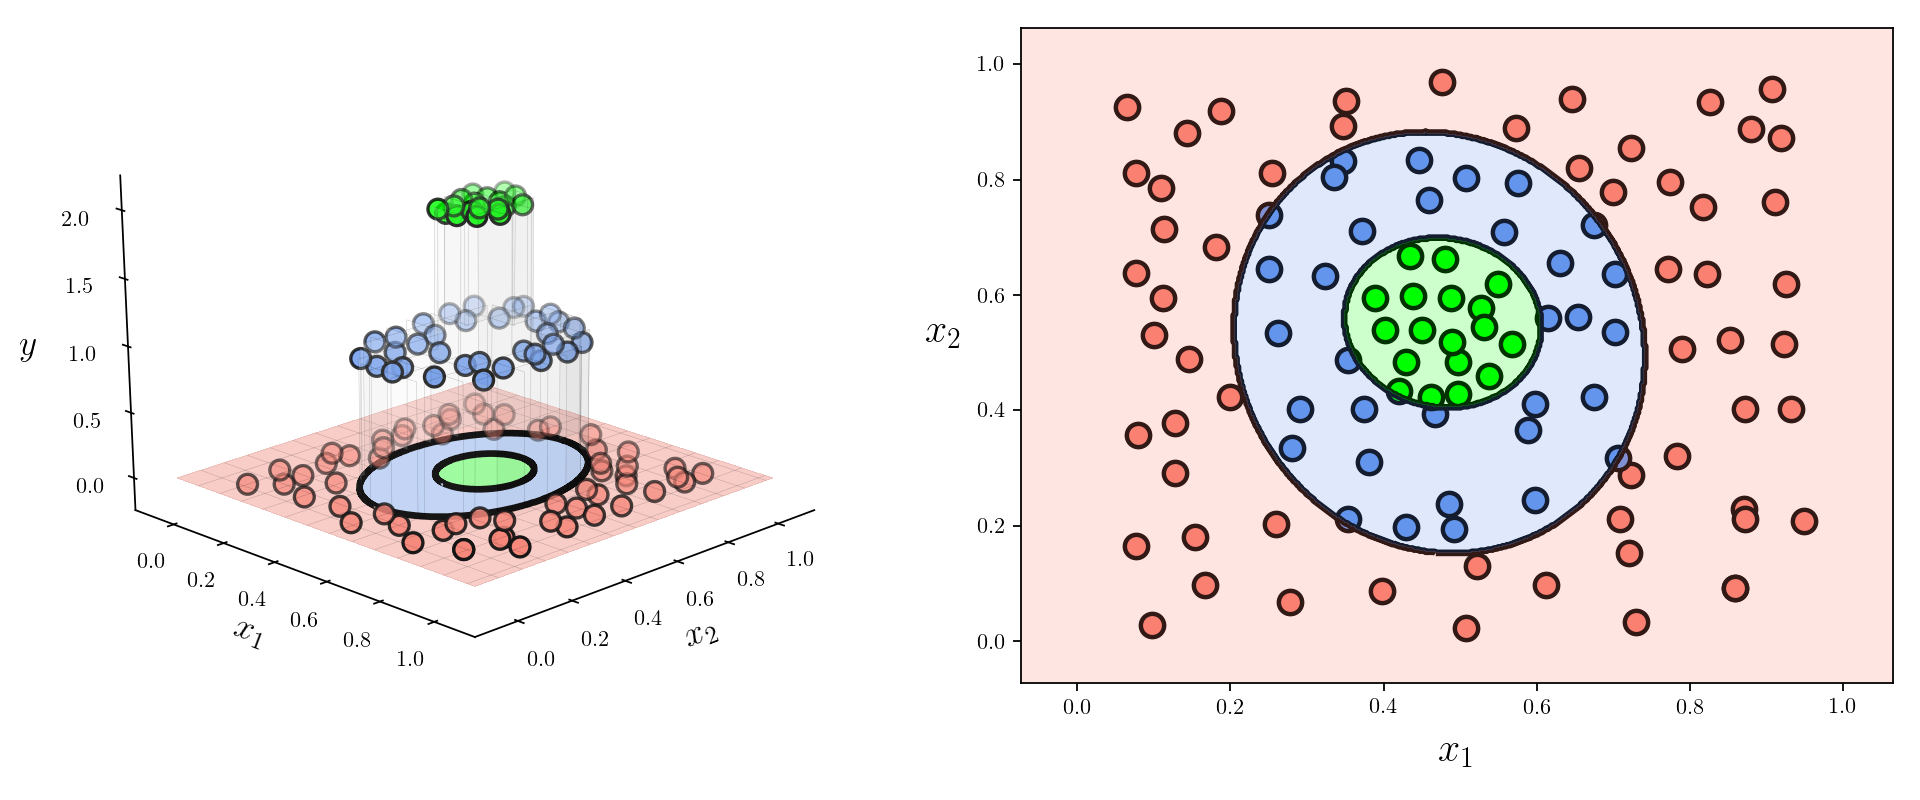

In [53]:
# plot result of nonlinear multiclass classification
w_best = combined_weights[-1]
demo.multiclass_plot(run,w_best)